# metrics to quantify text reuse (similarity between text A and B)

+ metric 1: sentence equality
+ metric 2: n-gram (n=4+ TODO test parameter)
+ metric 3: embeddings (S-BERT transformer + cosine similarity between vectors)

### requirements

+ nltk (3.6.5)
+ sentence-transformers (2.2.0)
+ scikit-learn (1.0.2)
+ matplotlib (3.5.0)
+ numpy (1.21.4)
+ pandas (1.3.4)
+ seaborn (0.11.2)

In [1]:
# format cells using black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import re
import math
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from nltk import ngrams
from nltk.metrics import jaccard_distance
from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple

<IPython.core.display.Javascript object>

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<IPython.core.display.Javascript object>

### load data

In [3]:
path = os.path.abspath("")
data_df_rel = "data/df/"
data_df_ndb_abs = os.path.join(path, data_df_rel, "df_ndb_wikipedia.pkl")
corpus = pd.read_pickle(data_df_ndb_abs)
corpus_rows = corpus[corpus.columns[0]].count()
corpus

,ndb_n,ndb_sfz,gnd,ndb_sex,ndb_name,wikipedia_title,ndb_text,wikipedia_text
0,n01-001-01,sfz45545,118643525,1,"Aachen Hans von (Johann von Achen, Hans Ach)",Hans von Aachen,"Karel van Mander (Schilderboeck, Haarlem 1604 ...",Hans von Aachen (* 1552 in Köln; † 4. März 161...
1,n01-001-02,sfz15,118500015,1,"Aal (Anguilla), Johannes",Johannes Aal,A.Aal verfocht zur Zeit der Reformation die al...,Johannes Aal (* um 1500 in Bremgarten AG; † 28...
2,n01-002-01,sfz17,104198273,1,dall' Abaco Evaristo Felice,Evaristo Felice Dall’Abaco,A.Abaco kam aus Verona über Modena 1704 an den...,Evaristo Felice Dall’Abaco (* 12. Juli 1675 in...
3,n01-002-02,sfz19,100002307,1,Abbadie Jacques,Jacques Abbadie,A.Abbadie studierte auf den Akademien von Saum...,"Jacques Abbadie, auch James, Jacobus oder Jaco..."
4,n01-002-03,sfz7153,118646419,1,Abbe Ernst Carl,Ernst Abbe,"Die Einsicht der Lehrer, die die außerordentli...",Ernst Karl Abbe [ˈabə] (* 23. Januar 1840 in ...
...,...,...,...,...,...,...,...,...
20479,n27-908-01,sfz141086,1116026791,2,Westphal-Hellbusch Sigrid Hellbusch,Sigrid Westphal-Hellbusch,Nach der Reifeprüfung am I. Oberlyzeum in Berl...,Sigrid Westphal-Hellbusch (* 10. Juni 1915 in ...
20480,n27-909-01,sfz60626,117327328,1,Westphalen Ferdinand,Ferdinand von Westphalen,W. Westphalen besuchte das Gymnasium in Salzw...,Ferdinand Otto Wilhelm Henning von Westphalen ...
20481,n27-910-01,sfz85259,117327573,1,Westrumb Friedrich,Johann Friedrich Westrumb,W. Westrumb begann 1764 eine Lehre in der kgl...,Johann Friedrich Westrumb (* 2. Dezember 1751 ...
20482,n27-911-01,sfz141099,1051891450,1,Wetter Ernst,Ernst Wetter,Nach der Volksschule absolvierte W. Wetter d...,Ernst Wetter (* 27. August 1877 in Töss (heute...


<IPython.core.display.Javascript object>

## utility functions

In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

<IPython.core.display.Javascript object>

In [7]:
def get_sentences(text: str) -> List[str]:
    return sent_tokenize(text, language="german")


def remove_punctuation_sent(sentences: List[str]) -> List[str]:
    sentences_clean = []
    for sent in sentences:
        words_clean = []
        words = word_tokenize(sent, language="german")
        for word in words:
            word_clean = [c for c in word if c not in string.punctuation]
            if word_clean:
                words_clean.append("".join(word_clean))
        sentences_clean.append(" ".join(words_clean))
    return sentences_clean


def remove_punctuation_text(text: str) -> str:
    words_clean = []
    words = word_tokenize(text, language="german")
    for word in words:
        word_clean = [c for c in word if c not in string.punctuation]
        if word_clean:
            words_clean.append("".join(word_clean))
    return " ".join(words_clean)


def remove_short_sentences(sentences: List[str], min_size: int) -> List[str]:
    return [
        s for s in sentences if len(word_tokenize(s, language="german")) >= min_size
    ]


def get_sentence_equality(ndb_text: str, wikipedia_text: str) -> Tuple[float, int, int]:
    """Return: sentence_reuse, ndb_wikipedia_sent_match_count, ndb_sent_clean_long_count"""
    # get sentences
    ndb_sent = get_sentences(ndb_text)
    wikipedia_sent = get_sentences(wikipedia_text)
    # remove punctuation
    ndb_sent_clean = remove_punctuation_sent(ndb_sent)
    wikipedia_sent_clean = remove_punctuation_sent(wikipedia_sent)
    # remove sentences that are too short (<5 words)
    ndb_sent_clean_long = remove_short_sentences(ndb_sent_clean, min_size=5)
    wikipedia_sent_clean_long = remove_short_sentences(wikipedia_sent_clean, min_size=5)

    ndb_sent_clean_long_count = len(ndb_sent_clean_long)
    if ndb_sent_clean_long_count == 0:
        # ZeroDivisionError
        return (0, 0, 0)
    ndb_wikipedia_sent_match_count = 0
    for sent in ndb_sent_clean_long:
        if sent in wikipedia_sent_clean_long:
            ndb_wikipedia_sent_match_count += 1
    sentence_reuse = ndb_wikipedia_sent_match_count / ndb_sent_clean_long_count
    return (sentence_reuse, ndb_wikipedia_sent_match_count, ndb_sent_clean_long_count)


def get_ngram_equality(ndb_text: str, wikipedia_text: str, n: int) -> float:
    """Return: ngram_reuse, ndb_wikipedia_ngram_match_count, ndb_ngram_clean_long_count"""
    # TODO check jaccard metric

    # remove punctuation and tokenize
    ndb_text_clean = remove_punctuation_text(ndb_text)
    ndb_words = word_tokenize(ndb_text_clean, language="german")
    wikipedia_text_clean = remove_punctuation_text(wikipedia_text)
    wikipedia_words = word_tokenize(wikipedia_text_clean, language="german")
    # ngrams and sets
    ndb_ngram = ngrams(ndb_words, n)
    ndb_ngram_set = set(ndb_ngram)
    wikipedia_ngram = ngrams(wikipedia_words, n)
    wikipedia_ngram_set = set(wikipedia_ngram)
    if len(ndb_ngram_set) == 0:
        return 0
    # intersection ndb wikipedia / ndb   --TODO measure with jaccard-metric: 1-(intersect/union):=union-intersect/union
    return len(ndb_ngram_set.intersection(wikipedia_ngram_set)) / len(ndb_ngram_set)


st_model_name = "bert-base-nli-mean-tokens"
st_model = SentenceTransformer(st_model_name)


def get_embedding_similarity(ndb_text: str, wikipedia_text: str) -> Tuple[List[float],List[float],int,int]:
    # get sentences
    ndb_sent = get_sentences(ndb_text)
    wikipedia_sent = get_sentences(wikipedia_text)
    # remove punctuation
    ndb_sent_clean = remove_punctuation_sent(ndb_sent)
    wikipedia_sent_clean = remove_punctuation_sent(wikipedia_sent)
    # remove sentences that are too short (<5 words)
    ndb_sent_clean_long = remove_short_sentences(ndb_sent_clean, min_size=5)
    wikipedia_sent_clean_long = remove_short_sentences(wikipedia_sent_clean, min_size=5)

    if len(ndb_sent_clean_long) == 0 or len(wikipedia_sent_clean_long) == 0:
        return ([],[],len(ndb_sent_clean_long),len(wikipedia_sent_clean_long))

    sentences = ndb_sent_clean_long + wikipedia_sent_clean_long
    sentences_vectors = st_model.encode(sentences)
    max_values_ndb = []
    for i in range(len(ndb_sent_clean_long)):
        values = cosine_similarity(
            [sentences_vectors[i]], sentences_vectors[len(ndb_sent_clean_long) :]
        )
        max_values_ndb.append(max(values[0]))
    assert len(max_values_ndb) == len(ndb_sent_clean_long)
    max_values_wikipedia = []
    for i in range(len(wikipedia_sent_clean_long)):
        values = cosine_similarity(
            [sentences_vectors[len(ndb_sent_clean_long)+i]], sentences_vectors[:len(ndb_sent_clean_long)]
        )
        max_values_wikipedia.append(max(values[0]))
    assert len(max_values_wikipedia) == len(wikipedia_sent_clean_long)
    return (max_values_ndb,max_values_wikipedia,len(ndb_sent_clean_long),len(wikipedia_sent_clean_long))

<IPython.core.display.Javascript object>

In [4]:
cwd = os.getcwd()
revisions_rel_path = "data/revisions/"
revisions_abs_path = os.path.join(cwd, revisions_rel_path)
directory = os.fsencode(revisions_abs_path)

revisions_meta_rel_path = "data/revisions_meta/"
revisions_meta_abs_path = os.path.join(cwd, revisions_meta_rel_path)

pattern_filename_gnd = re.compile(r"^([\w\d]+)|.*.pkl$")
pattern_year_month = re.compile(r"^\d{4}-\d{2}")

caps = [0, 0.25, 0.5, 0.75, 1]

<IPython.core.display.Javascript object>

In [5]:
plt.rcParams["figure.figsize"] = [10, 5]

<IPython.core.display.Javascript object>

## metric 1: sentence equality

In [ ]:
sentence_reuse_values = []  # (val,val_abs,len) --for example (0.2,4,20)

_eval = []
_iter = 0
for index, row in corpus.iterrows():
    _iter += 1
    print(f"processed files: {_iter}/{corpus_rows}", end="\r")
    # get text
    ndb_text = row["ndb_text"]
    wikipedia_text = row["wikipedia_text"]
    # get sentences
    ndb_sent = get_sentences(ndb_text)
    wikipedia_sent = get_sentences(wikipedia_text)
    # remove punctuation
    ndb_sent_clean = remove_punctuation_sent(ndb_sent)
    wikipedia_sent_clean = remove_punctuation_sent(wikipedia_sent)
    # remove sentences that are too short (<5 words)
    ndb_sent_clean_long = remove_short_sentences(ndb_sent_clean, min_size=5)
    wikipedia_sent_clean_long = remove_short_sentences(wikipedia_sent_clean, min_size=5)

    ndb_sent_clean_long_count = len(ndb_sent_clean_long)
    if ndb_sent_clean_long_count == 0:
        # ZeroDivisionError
        sentence_reuse_values.append((0, 0, 0))
        _eval.append(
            {
                "ndb_text": ndb_text,
                "ndb_sent": ndb_sent,
                "ndb_sent_clean": ndb_sent_clean,
                "ndb_sent_clean_long": ndb_sent_clean_long,
            }
        )
        continue
    ndb_wikipedia_sent_match_count = 0
    for sent in ndb_sent_clean_long:
        if sent in wikipedia_sent_clean_long:
            ndb_wikipedia_sent_match_count += 1
    sentence_reuse = ndb_wikipedia_sent_match_count / ndb_sent_clean_long_count
    sentence_reuse_values.append(
        (sentence_reuse, ndb_wikipedia_sent_match_count, ndb_sent_clean_long_count)
    )

sentence_reuse_values.sort(key=lambda x: x[0], reverse=True)
print("")
print("length of ndb_sent_clean_long == 0: ", len(_eval))

In [40]:
sentence_reuse_values[:20]

[(0.5, 2, 4),
 (0.5, 1, 2),
 (0.5, 4, 8),
 (0.5, 3, 6),
 (0.3333333333333333, 1, 3),
 (0.3333333333333333, 3, 9),
 (0.3333333333333333, 2, 6),
 (0.3225806451612903, 10, 31),
 (0.3076923076923077, 4, 13),
 (0.2857142857142857, 2, 7),
 (0.2857142857142857, 4, 14),
 (0.2857142857142857, 2, 7),
 (0.25, 1, 4),
 (0.25, 1, 4),
 (0.25, 1, 4),
 (0.25, 1, 4),
 (0.25, 6, 24),
 (0.25, 2, 8),
 (0.21428571428571427, 3, 14),
 (0.2, 1, 5)]

<IPython.core.display.Javascript object>

In [46]:
print("equal sentences found: ", sum([v[1] for v in sentence_reuse_values]))
print("reuse median: ", np.median([v[0] for v in sentence_reuse_values]))
print("reuse mean: ", np.mean([v[0] for v in sentence_reuse_values]))
print("reuse max: ", max([v[0] for v in sentence_reuse_values]))
print("reuse min: ", min([v[0] for v in sentence_reuse_values]))
print("")
print("median ndb sentences count: ", np.median([v[2] for v in sentence_reuse_values]))
print("mean ndb sentences count: ", np.mean([v[2] for v in sentence_reuse_values]))

equal sentences found:  342
reuse median:  0.0
reuse mean:  0.0011591444525515348
reuse max:  0.5
reuse min:  0.0

median ndb sentences count:  16.0
mean ndb sentences count:  18.971538761960556


<IPython.core.display.Javascript object>

In [38]:
_eval

[{'ndb_text': 'In Österreich, Metallwarenindustrielle',
  'ndb_sent': ['In Österreich, Metallwarenindustrielle'],
  'ndb_sent_clean': ['In Österreich Metallwarenindustrielle'],
  'ndb_sent_clean_long': []},
 {'ndb_text': 'Siehe Georg von Opel.',
  'ndb_sent': ['Siehe Georg von Opel.'],
  'ndb_sent_clean': ['Siehe Georg von Opel'],
  'ndb_sent_clean_long': []},
 {'ndb_text': 'Siehe Georg von Opel.',
  'ndb_sent': ['Siehe Georg von Opel.'],
  'ndb_sent_clean': ['Siehe Georg von Opel'],
  'ndb_sent_clean_long': []},
 {'ndb_text': 'Siehe Georg von Opel.',
  'ndb_sent': ['Siehe Georg von Opel.'],
  'ndb_sent_clean': ['Siehe Georg von Opel'],
  'ndb_sent_clean_long': []},
 {'ndb_text': 'Siehe Georg von Opel.',
  'ndb_sent': ['Siehe Georg von Opel.'],
  'ndb_sent_clean': ['Siehe Georg von Opel'],
  'ndb_sent_clean_long': []},
 {'ndb_text': 'Siehe Georg von Opel.',
  'ndb_sent': ['Siehe Georg von Opel.'],
  'ndb_sent_clean': ['Siehe Georg von Opel'],
  'ndb_sent_clean_long': []},
 {'ndb_text':

<IPython.core.display.Javascript object>

### boxplots

In [61]:
_rel, _abs, _len = [list(t) for t in zip(*sentence_reuse_values)]

<IPython.core.display.Javascript object>

{'whiskers': [<matplotlib.lines.Line2D at 0x7f623e39baf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f623e3aa0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f623e39b820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f623e3aa670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f623e3aa940>],
 'means': []}

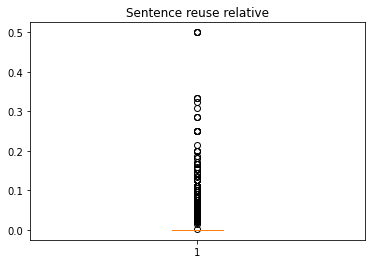

<IPython.core.display.Javascript object>

In [62]:
fig1, ax1 = plt.subplots()
ax1.set_title("Sentence reuse relative")
ax1.boxplot(_rel)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f623e37f820>,
 'caps': [<matplotlib.lines.Line2D at 0x7f623e37fdc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f623e37f550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f623e30e3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f623e30e670>],
 'means': []}

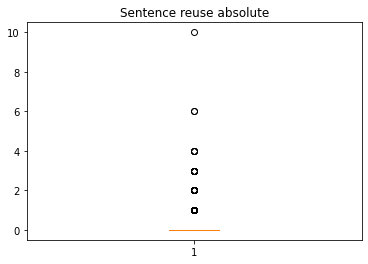

<IPython.core.display.Javascript object>

In [63]:
fig1, ax1 = plt.subplots()
ax1.set_title("Sentence reuse absolute")
ax1.boxplot(_abs)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f623e2e09a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f623e2e0f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f623e2e06d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f623e2f1520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f623e2f17f0>],
 'means': []}

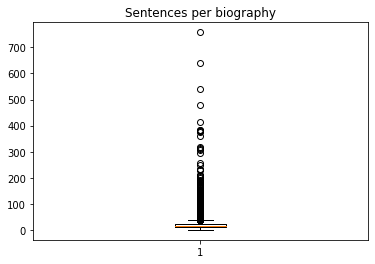

<IPython.core.display.Javascript object>

In [64]:
fig1, ax1 = plt.subplots()
ax1.set_title("Sentences per biography")
ax1.boxplot(_len)

### time dimension for metric 1: reuse for wikipedia version after 0% 25% 50% 75% 100% revisions

In [73]:
sentence_reuse_versions = [[], [], [], [], []]

k = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        k += 1
        print(f"processed files: {k}", end="\r")
        biography_revisions_abs = os.path.join(revisions_abs_path, filename)
        df = pd.read_pickle(biography_revisions_abs)

        gnd = pattern_filename_gnd.search(filename).group(0)
        revision_by_gnd_meta_abs = os.path.join(revisions_meta_abs_path, gnd + ".pkl")
        meta = None
        with open(revision_by_gnd_meta_abs, "rb") as f:
            meta = pickle.load(f)
        # number of rows in df == number of months with >0 revisions in meta
        assert df[df.columns[0]].count() == sum(
            {k: 1 for k, v in meta["months"].items() if v > 0}.values()
        )

        # ndb text
        ndb_text = corpus.loc[corpus["gnd"] == gnd, "ndb_text"].item()

        number_revisions = sum(meta["months"].values())

        # get first monthly revision
        # get monthy revision after 25% revisions
        # get monthy revision after 50% revisions
        # get monthy revision after 75% revisions
        # get last monthly revision

        # calculate revision thresholds
        thresholds_revision_number = [
            max(min(math.ceil(number_revisions * x), number_revisions), 1) for x in caps
        ]
        thresholds_year_months = []
        for threshold in thresholds_revision_number:
            revisions_iter_sum = 0
            for year_month, v in meta["months"].items():
                revisions_iter_sum += v
                if revisions_iter_sum >= threshold:
                    thresholds_year_months.append(year_month)
                    break
        assert len(thresholds_year_months) == len(caps)
        wikipedia_texts = []
        for threshold_year_month in thresholds_year_months:
            for index, row in df.iterrows():
                timestamp = row["timestamp"]
                year_month = pattern_year_month.search(timestamp).group(0)
                if year_month == threshold_year_month:
                    wikipedia_texts.append(row["text"])
                    break
        assert len(wikipedia_texts) == len(caps)
        # status quo(txt): ndb and 5 wikipedia versions (first,after 25% rev, after 50% rev, after 75% rev,last)
        for i, wikipedia_text in enumerate(wikipedia_texts):
            sentence_reuse_versions[i].append(
                get_sentence_equality(ndb_text, wikipedia_text)
            )
with open(os.path.join(cwd, "data/reuse/", "sentence_equality.pkl"), "wb") as f:
    pickle.dump(sentence_reuse_versions, f)

<IPython.core.display.Javascript object>

In [8]:
data = None
sent_equality = None
with open(os.path.join(cwd, "data/reuse/", "sentence_equality.pkl"), "rb") as f:
    data = pickle.load(f)
    sent_equality = [[v[0] for v in x] for x in data]

<IPython.core.display.Javascript object>

In [23]:
sent_equality_dict = {
    "first rev": sent_equality[0],
    "25% rev": sent_equality[1],
    "50% rev": sent_equality[2],
    "75% rev": sent_equality[3],
    "last rev": sent_equality[4],
}

<IPython.core.display.Javascript object>

In [24]:
print("equal sentences:\n")
for i, d in enumerate(data):
    equal_sentences_nr = sum(
        [x for x in sorted([y[1] for y in d], reverse=True) if x > 0]
    )
    k = list(sent_equality_dict.keys())[i]
    print(f"{k}: {equal_sentences_nr}")

equal sentences:

first rev: 280
25% rev: 305
50% rev: 335
75% rev: 334
last rev: 337


<IPython.core.display.Javascript object>

### check correlation between equal sentences and the amount of sentences per biography

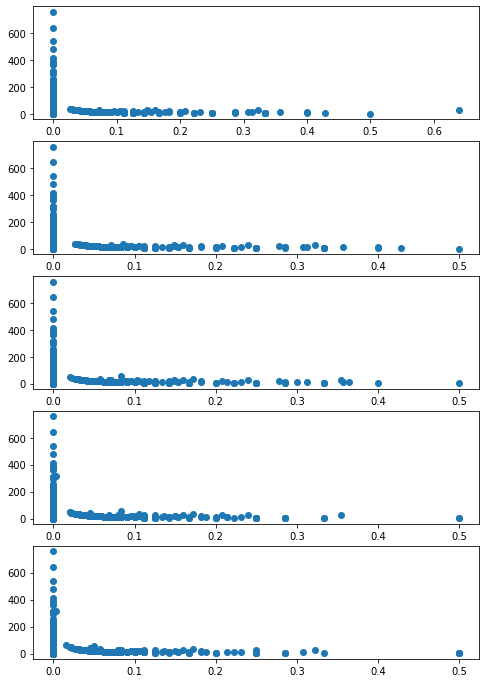

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(5, 1, figsize=(8, 12))
for i, vals in enumerate(data):
    _x, _y = map(list, zip(*[(x, z) for (x, y, z) in vals]))
    ax[i].scatter(_x, _y)

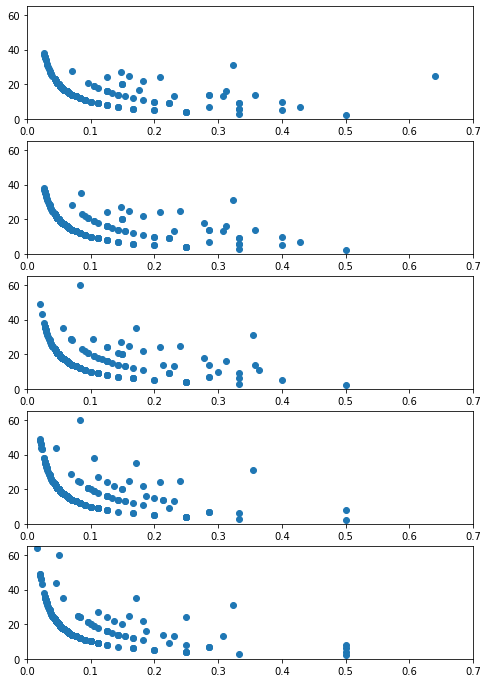

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(5, 1, figsize=(8, 12))
for i, vals in enumerate(data):
    _x, _y, _z = map(list, zip(*[(x, y, z) for (x, y, z) in vals if y > 0]))
    ax[i].scatter(_x, _z)
    ax[i].set_xlim(0, 0.7)
    ax[i].set_ylim(0, 65)

(0.0, 65.0)

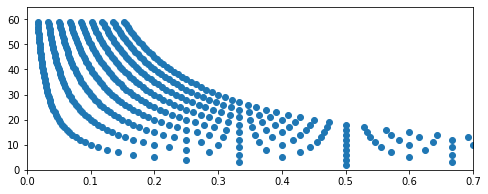

<IPython.core.display.Javascript object>

In [55]:
# kurven :: abs anzahl an sätzen die übereinstimmen (1te kurve: 1 satz stimmt überein)
plt.rcParams["figure.figsize"] = [8, 3]
x = []
y = []
for i in range(1, 10):
    for j in range(i, 60):
        y.append(j)
        x.append(i / j)
plt.scatter(x, y)
plt.xlim(0, 0.7)
plt.ylim(0, 65)

In [23]:
plt.rcParams["figure.figsize"] = [5, 3]
fst_abs = np.array([y for (x, y, z) in data[0]])
last_abs = np.array([y for (x, y, z) in data[4]])
diff = fst_abs - last_abs

<IPython.core.display.Javascript object>

Text(0, 0.5, 'biographies')

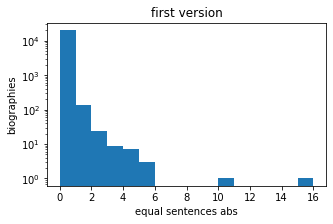

<IPython.core.display.Javascript object>

In [21]:
plt.hist(fst_abs, bins=np.arange(0, 17, 1))
plt.yscale("log")
plt.title("first version")
plt.xlabel("equal sentences abs")
plt.ylabel("biographies")

Text(0, 0.5, 'biographies')

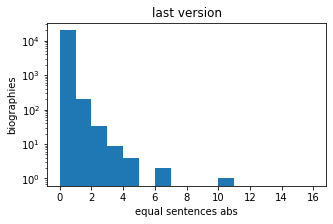

<IPython.core.display.Javascript object>

In [22]:
plt.hist(last_abs, np.arange(0, 17, 1))
plt.yscale("log")
plt.title("last version")
plt.xlabel("equal sentences abs")
plt.ylabel("biographies")

Text(0, 0.5, 'biographies')

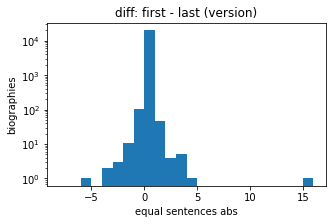

<IPython.core.display.Javascript object>

In [26]:
plt.hist(diff, bins=np.arange(-8, 17, 1))
plt.yscale("log")
plt.title("diff: first - last (version)")
plt.xlabel("equal sentences abs")
plt.ylabel("biographies")

In [15]:
print(len(diff[diff < 0]) / len(diff[diff > 0]))

2.0701754385964914


<IPython.core.display.Javascript object>

In [ ]:
# >1 -> kommt mehr dazu (,aber wie viel?)

### eval boxplots

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

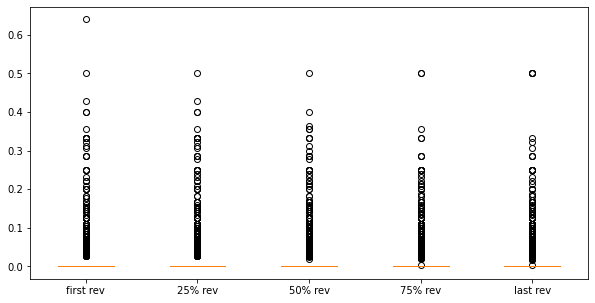

<IPython.core.display.Javascript object>

In [87]:
fig, ax = plt.subplots()
ax.boxplot(sent_equality_dict.values())
ax.set_xticklabels(sent_equality_dict.keys())

In [88]:
sent_equality_dict_zeros_removed = {
    k: [x for x in v if x > 0] for k, v in sent_equality_dict.items()
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

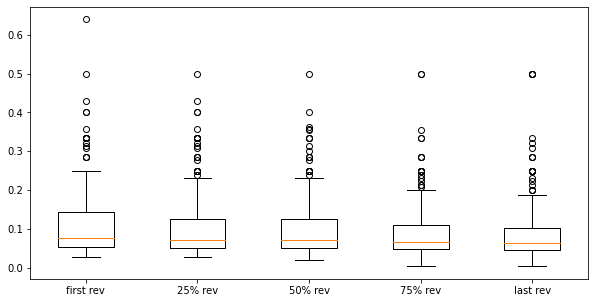

<IPython.core.display.Javascript object>

In [89]:
fig, ax = plt.subplots()
ax.boxplot(sent_equality_dict_zeros_removed.values())
ax.set_xticklabels(sent_equality_dict_zeros_removed.keys())

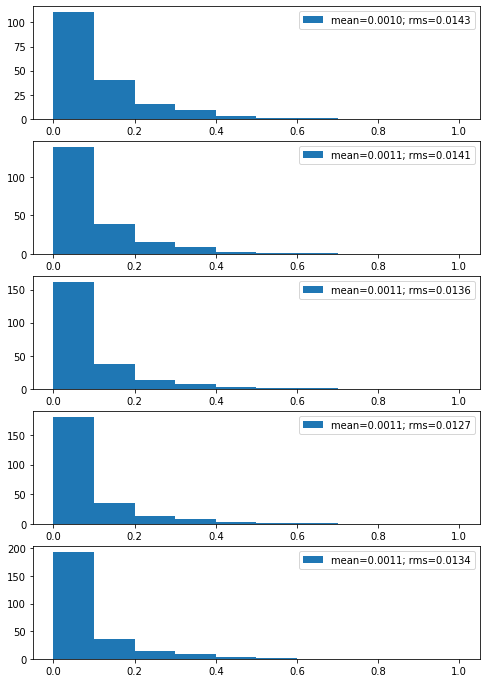

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(5, 1, figsize=(8, 12))
for i, key in enumerate(sent_equality_dict_zeros_removed):
    tmp = np.array(sent_equality_dict[key])
    ax[i].hist(
        temp[tmp > 0],
        label=f"mean={np.mean(tmp):.4f}; rms={np.std(tmp):.4f}",  # mean and  rms from all datapoints!
        bins=np.arange(0, 1.1, 0.1),
    )
    ax[i].legend(loc="best")

### logplot

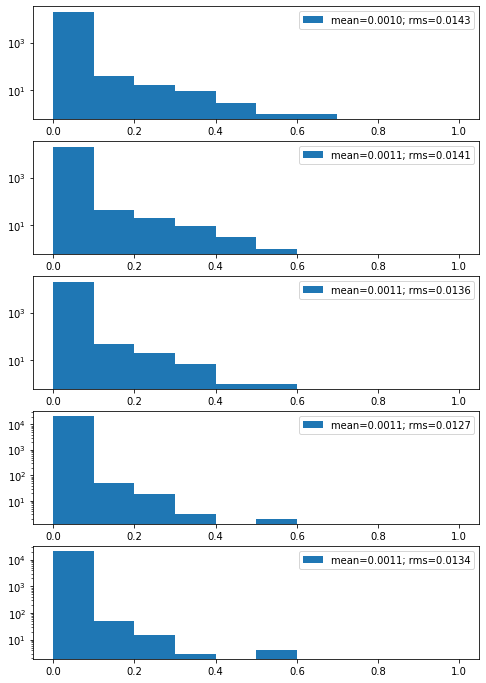

<IPython.core.display.Javascript object>

In [99]:
fig, ax = plt.subplots(5, 1, figsize=(8, 12))
for i, key in enumerate(sent_equality_dict):
    tmp = np.array(sent_equality_dict[key])
    bins = np.arange(0, 1.1, 0.1)
    ax[i].hist(
        tmp, bins, label=f"mean={np.mean(tmp):.4f}; rms={np.std(tmp):.4f}"
    )  # root mean squared
    ax[i].set_yscale("log")
    ax[i].legend(loc="best")

### violinplot

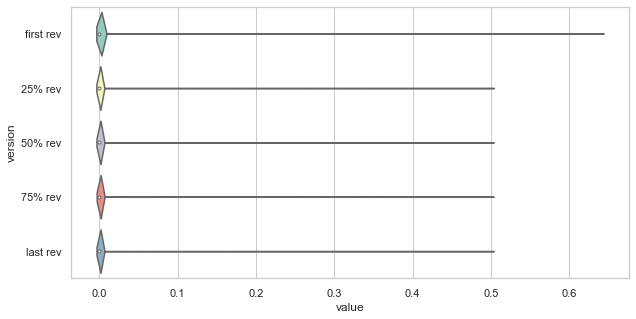

<IPython.core.display.Javascript object>

In [144]:
df_dict = {"version": [], "value": []}
for k, v in sent_equality_dict.items():
    df_dict["version"] += [k for i in range(len(v))]
    df_dict["value"] += v
df_vp = pd.DataFrame.from_dict(df_dict)
ax = sns.violinplot(
    x="value",
    y="version",
    data=df_vp,
    scale="width",
    palette="Set3",
)

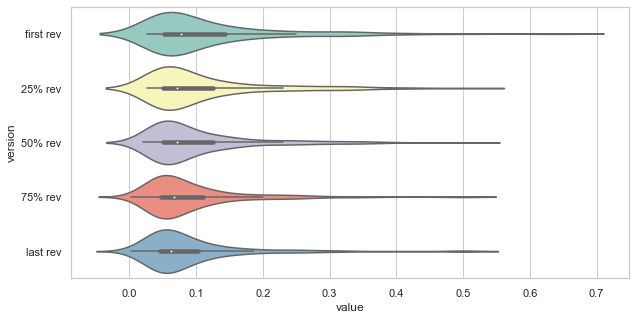

<IPython.core.display.Javascript object>

In [145]:
df_dict = {"version": [], "value": []}
for k, v in sent_equality_dict.items():
    df_dict["version"] += [k for i in range(len(v))]
    df_dict["value"] += v
df_vp = pd.DataFrame.from_dict(df_dict)
ax = sns.violinplot(
    x="value",
    y="version",
    data=df_vp[df_vp.value > 0],
    scale="width",
    palette="Set3",
)

## metric 2: n-gram (n=4,5,6,7)

In [ ]:
#TODO Jaccard Coefficient p.241,https://link.springer.com/content/pdf/10.1007/978-3-642-22348-8_19.pdf

In [80]:
# len of each inner list:20457
ngram_reuse_versions = [[], [], [], [], []]
n = 7

k = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        k += 1
        print(f"processed files: {k}", end="\r")
        biography_revisions_abs = os.path.join(revisions_abs_path, filename)
        df = pd.read_pickle(biography_revisions_abs)

        gnd = pattern_filename_gnd.search(filename).group(0)
        revision_by_gnd_meta_abs = os.path.join(revisions_meta_abs_path, gnd + ".pkl")
        meta = None
        with open(revision_by_gnd_meta_abs, "rb") as f:
            meta = pickle.load(f)
        # number of rows in df == number of months with >0 revisions in meta
        assert df[df.columns[0]].count() == sum(
            {k: 1 for k, v in meta["months"].items() if v > 0}.values()
        )

        # ndb text
        ndb_text = corpus.loc[corpus["gnd"] == gnd, "ndb_text"].item()

        number_revisions = sum(meta["months"].values())

        # get first monthly revision
        # get monthy revision after 25% revisions
        # get monthy revision after 50% revisions
        # get monthy revision after 75% revisions
        # get last monthly revision

        # calculate revision thresholds
        thresholds_revision_number = [
            max(min(math.ceil(number_revisions * x), number_revisions), 1) for x in caps
        ]
        thresholds_year_months = []
        for threshold in thresholds_revision_number:
            revisions_iter_sum = 0
            for year_month, v in meta["months"].items():
                revisions_iter_sum += v
                if revisions_iter_sum >= threshold:
                    thresholds_year_months.append(year_month)
                    break
        assert len(thresholds_year_months) == len(caps)
        wikipedia_texts = []
        for threshold_year_month in thresholds_year_months:
            for index, row in df.iterrows():
                timestamp = row["timestamp"]
                year_month = pattern_year_month.search(timestamp).group(0)
                if year_month == threshold_year_month:
                    wikipedia_texts.append(row["text"])
                    break
        assert len(wikipedia_texts) == len(caps)
        # status quo(txt): ndb and 5 wikipedia versions (first,after 25% rev, after 50% rev, after 75% rev,last)
        for i, wikipedia_text in enumerate(wikipedia_texts):
            ngram_reuse_versions[i].append(
                get_ngram_equality(ndb_text, wikipedia_text, n=n)
            )
with open(os.path.join(cwd, "data/reuse/", str(n) + "-gram_equality.pkl"), "wb") as f:
    pickle.dump(ngram_reuse_versions, f)

<IPython.core.display.Javascript object>

### boxplots

### 4-gram (n=4)

In [60]:
data = None
with open(os.path.join(cwd, "data/reuse/", "4-gram_equality.pkl"), "rb") as f:
    data = pickle.load(f)

<IPython.core.display.Javascript object>

In [61]:
ngram_equality_dict = {
    "first rev": data[0],
    "25% rev": data[1],
    "50% rev": data[2],
    "75% rev": data[3],
    "last rev": data[4],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

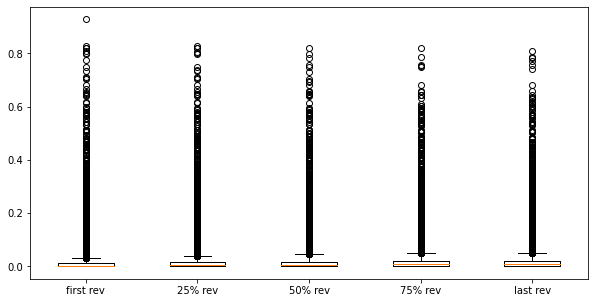

<IPython.core.display.Javascript object>

In [65]:
fig, ax = plt.subplots()
ax.boxplot(ngram_equality_dict.values())
ax.set_xticklabels(ngram_equality_dict.keys())

### 5-gram (n=5)

In [71]:
data = None
with open(os.path.join(cwd, "data/reuse/", "5-gram_equality.pkl"), "rb") as f:
    data = pickle.load(f)

<IPython.core.display.Javascript object>

In [72]:
ngram_equality_dict = {
    "first rev": data[0],
    "25% rev": data[1],
    "50% rev": data[2],
    "75% rev": data[3],
    "last rev": data[4],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

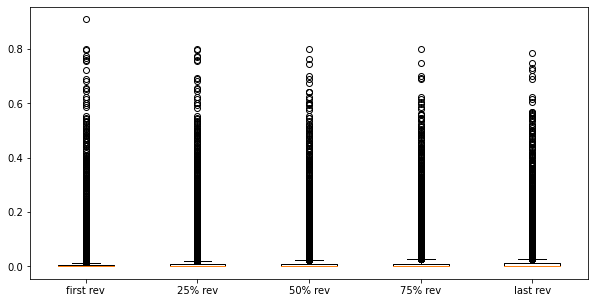

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plt.subplots()
ax.boxplot(ngram_equality_dict.values())
ax.set_xticklabels(ngram_equality_dict.keys())

### 6-gram (n=6)

In [77]:
data = None
with open(os.path.join(cwd, "data/reuse/", "6-gram_equality.pkl"), "rb") as f:
    data = pickle.load(f)

<IPython.core.display.Javascript object>

In [78]:
ngram_equality_dict = {
    "first rev": data[0],
    "25% rev": data[1],
    "50% rev": data[2],
    "75% rev": data[3],
    "last rev": data[4],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

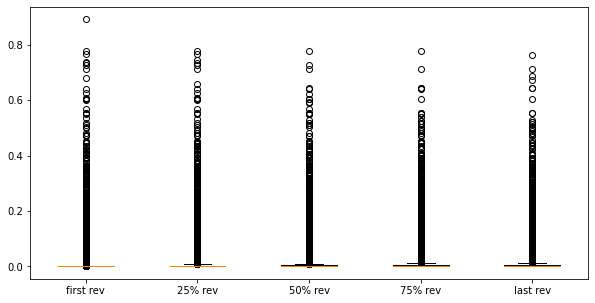

<IPython.core.display.Javascript object>

In [79]:
fig, ax = plt.subplots()
ax.boxplot(ngram_equality_dict.values())
ax.set_xticklabels(ngram_equality_dict.keys())

### 7-gram (n=7)

In [81]:
data = None
with open(os.path.join(cwd, "data/reuse/", "7-gram_equality.pkl"), "rb") as f:
    data = pickle.load(f)

<IPython.core.display.Javascript object>

In [82]:
ngram_equality_dict = {
    "first rev": data[0],
    "25% rev": data[1],
    "50% rev": data[2],
    "75% rev": data[3],
    "last rev": data[4],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

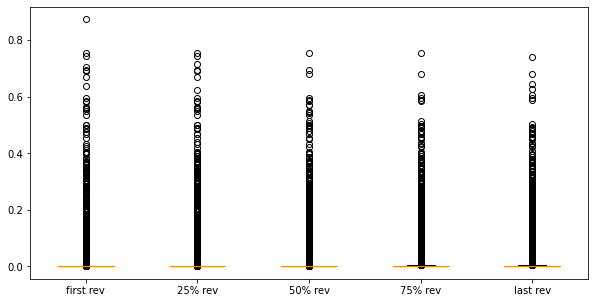

<IPython.core.display.Javascript object>

In [83]:
fig, ax = plt.subplots()
ax.boxplot(ngram_equality_dict.values())
ax.set_xticklabels(ngram_equality_dict.keys())

## metric 3: embeddings (BERT transformer + cosine similarity between vectors)

### run scrip
+ python run_sentence_embedding.py

## old model!!! deprecated

In [6]:
data = None
with open(os.path.join(cwd, "data/reuse/", "embedding_similarity.pkl"), "rb") as f:
    unpickler = pickle.Unpickler(f)
    data = unpickler.load()

<IPython.core.display.Javascript object>

+ ndb wiki

In [7]:
embedding_similarity_ndb_wiki = {
    "first rev": [np.mean(t[0]) for t in data[0] if t[0]],
    "25% rev": [np.mean(t[0]) for t in data[1] if t[0]],
    "50% rev": [np.mean(t[0]) for t in data[2] if t[0]],
    "75% rev": [np.mean(t[0]) for t in data[3] if t[0]],
    "last rev": [np.mean(t[0]) for t in data[4] if t[0]],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

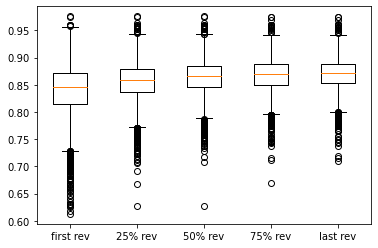

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots()
ax.boxplot(embedding_similarity_ndb_wiki.values())
ax.set_xticklabels(embedding_similarity_ndb_wiki.keys())

In [9]:
embedding_similarity_ndb_wiki_scatter = {
    "first rev": [(np.mean(t[0]),(t[2]-t[3])/(t[2]+t[3])) for t in data[0] if t[0]],
    "25% rev": [(np.mean(t[0]),(t[2]-t[3])/(t[2]+t[3])) for t in data[1] if t[0]],
    "50% rev": [(np.mean(t[0]),(t[2]-t[3])/(t[2]+t[3])) for t in data[2] if t[0]],
    "75% rev": [(np.mean(t[0]),(t[2]-t[3])/(t[2]+t[3])) for t in data[3] if t[0]],
    "last rev": [(np.mean(t[0]),(t[2]-t[3])/(t[2]+t[3])) for t in data[4] if t[0]],
}

<IPython.core.display.Javascript object>

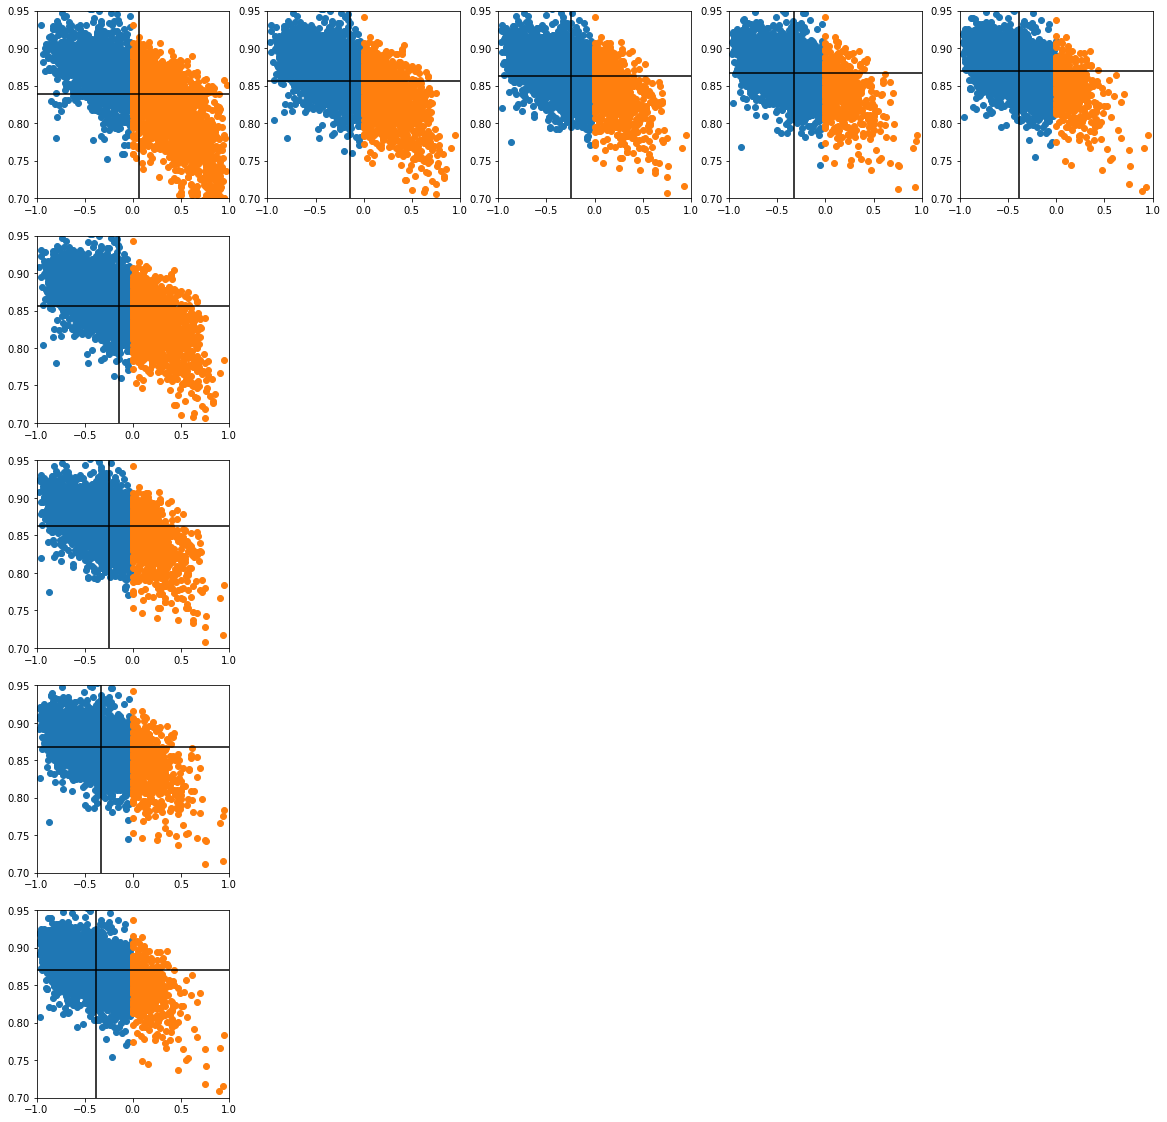

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(5,5, figsize=(20, 20))
for i, key in enumerate(embedding_similarity_ndb_wiki_scatter):
    y1,x1 = zip(*[t for t in embedding_similarity_ndb_wiki_scatter[key] if t[1]<0])
    y2,x2 = zip(*[t for t in embedding_similarity_ndb_wiki_scatter[key] if t[1]>=0])
    x_mean = np.mean(x1+x2)
    y_mean = np.mean(y1+y2)
    ax[0,i].axhline(y=y_mean, color='black')
    ax[0,i].axvline(x=x_mean, color='black')
    ax[0,i].scatter(x1,y1)
    ax[0,i].scatter(x2,y2)
    ax[0,i].set_xlim(-1,1)
    ax[0,i].set_ylim(0.70,0.95)
    if i!=0:
        ax[i,0].axhline(y=y_mean, color='black')
        ax[i,0].axvline(x=x_mean, color='black')
        ax[i,0].scatter(x1,y1)
        ax[i,0].scatter(x2,y2)
        ax[i,0].set_xlim(-1,1)
        ax[i,0].set_ylim(0.70,0.95)
    for j in range(1,5):
        for k in range(1,5):
            ax[j,k].set_visible(False)
    

+ wiki ndb

In [23]:
embedding_similarity_wiki_ndb = {
    "first rev": [np.mean(t[1]) for t in data[0] if t[1]],
    "25% rev": [np.mean(t[1]) for t in data[1] if t[1]],
    "50% rev": [np.mean(t[1]) for t in data[2] if t[1]],
    "75% rev": [np.mean(t[1]) for t in data[3] if t[1]],
    "last rev": [np.mean(t[1]) for t in data[4] if t[1]],
}

<IPython.core.display.Javascript object>

[Text(1, 0, 'first rev'),
 Text(2, 0, '25% rev'),
 Text(3, 0, '50% rev'),
 Text(4, 0, '75% rev'),
 Text(5, 0, 'last rev')]

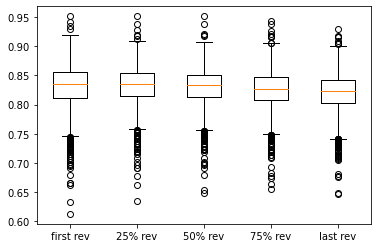

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots()
ax.boxplot(embedding_similarity_wiki_ndb.values())
ax.set_xticklabels(embedding_similarity_wiki_ndb.keys())

In [14]:
embedding_similarity_wiki_ndb_scatter = {
    "first rev": [(np.mean(t[1]),(t[2]-t[3])/(t[2]+t[3])) for t in data[0] if t[1]],
    "25% rev": [(np.mean(t[1]),(t[2]-t[3])/(t[2]+t[3])) for t in data[1] if t[1]],
    "50% rev": [(np.mean(t[1]),(t[2]-t[3])/(t[2]+t[3])) for t in data[2] if t[1]],
    "75% rev": [(np.mean(t[1]),(t[2]-t[3])/(t[2]+t[3])) for t in data[3] if t[1]],
    "last rev": [(np.mean(t[1]),(t[2]-t[3])/(t[2]+t[3])) for t in data[4] if t[1]],
}

<IPython.core.display.Javascript object>

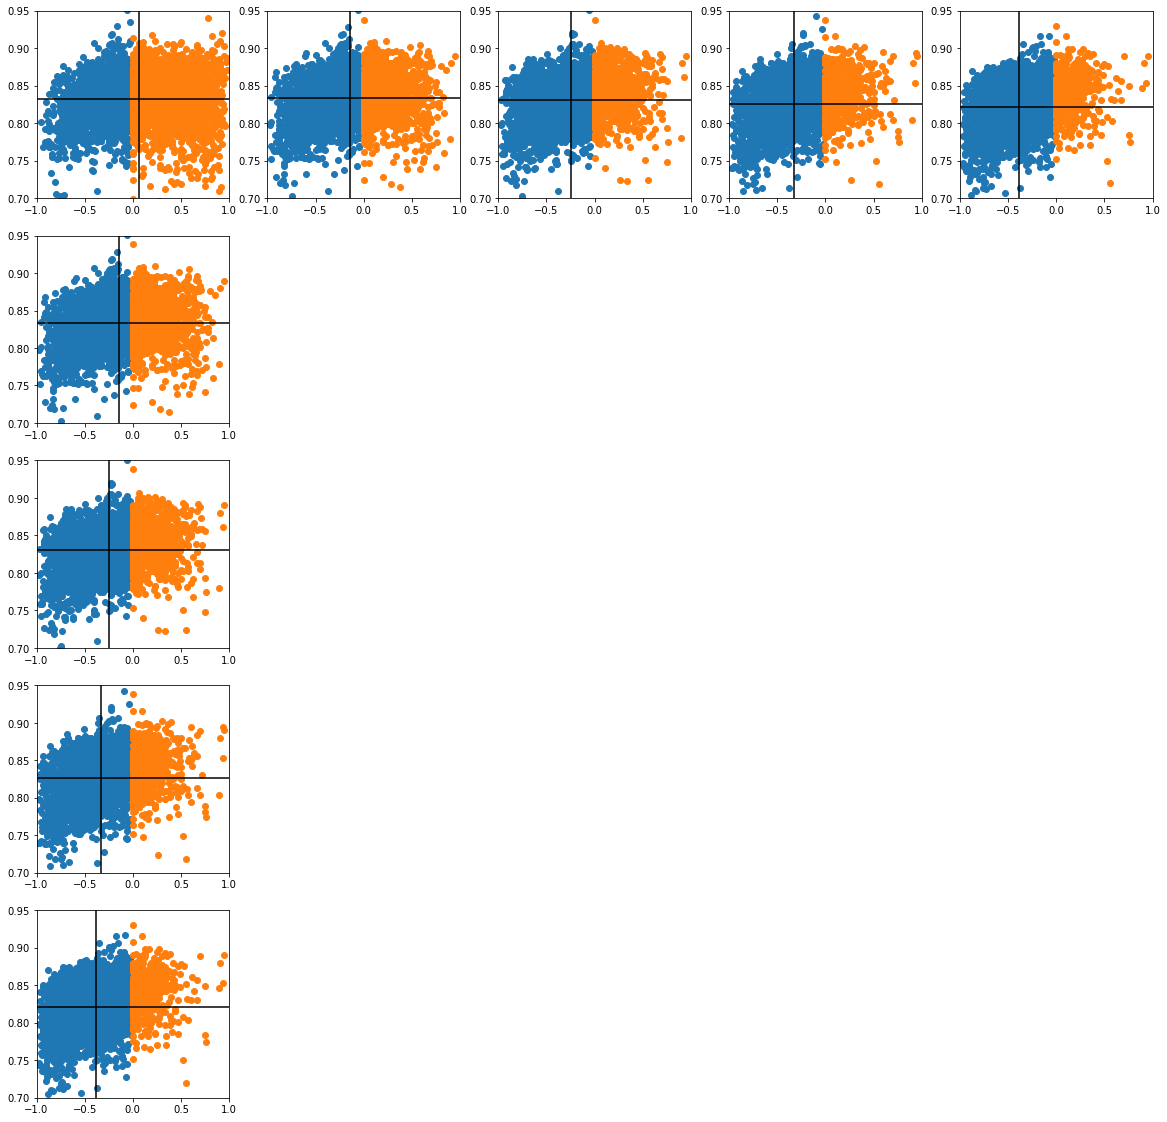

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, key in enumerate(embedding_similarity_wiki_ndb_scatter):
    y1,x1 = zip(*[t for t in embedding_similarity_wiki_ndb_scatter[key] if t[1]<0])
    y2,x2 = zip(*[t for t in embedding_similarity_wiki_ndb_scatter[key] if t[1]>=0])
    x_mean = np.mean(x1+x2)
    y_mean = np.mean(y1+y2)
    ax[0,i].axhline(y=y_mean, color='black')
    ax[0,i].axvline(x=x_mean, color='black')
    ax[0,i].scatter(x1,y1)
    ax[0,i].scatter(x2,y2)
    ax[0,i].set_xlim(-1,1)
    ax[0,i].set_ylim(0.70,0.95)
    if i!=0:
        ax[i,0].axhline(y=y_mean, color='black')
        ax[i,0].axvline(x=x_mean, color='black')
        ax[i,0].scatter(x1,y1)
        ax[i,0].scatter(x2,y2)
        ax[i,0].set_xlim(-1,1)
        ax[i,0].set_ylim(0.70,0.95)
    for j in range(1,5):
        for k in range(1,5):
            ax[j,k].set_visible(False)

## 6 pretrained models

+ check data gathering progress (6 scrips run parallel via jupytherlab)

In [ ]:
# check notebook sentence_transformer ... (filesize...)

## test code

### sentence similarity - sentence transformer approach (BERT)

In [4]:
ndb_sent_sample = []
wikipedia_sent_sample = []

for index, row in corpus.iterrows():
    ndb_text = row["ndb_text"]
    wikipedia_text = row["wikipedia_text"]
    ndb_sent = sent_tokenize(ndb_text, language="german")
    wikipedia_sent = sent_tokenize(wikipedia_text, language="german")

    print(f"{ndb_sent=}")
    print("\n")
    print(f"{wikipedia_sent=}")
    ndb_sent_sample = ndb_sent
    wikipedia_sent_sample = wikipedia_sent
    break

ndb_sent=['Karel van Mander (Schilderboeck, Haarlem 1604 und 1617) berichtet, A.Aachen habe seinen Namen nach der Herkunft seines Vaters geführt.', 'Seine künstlerische Laufbahn begann er in Köln als Schüler eines Giorgie oder Jerrigh genannten Niederländers, bei dem er sich insbesondere im Porträtmalen übte.', '1574-88 reiste er in Italien (Venedig, Rom, Florenz), 1588-1601 war er in Köln, Augsburg und am Hofe Wilhelms V. in München als Hofkammermaler tätig.', '1592 wurde er von Kaiser Rudolf II.', 'zu „Sr.Seiner Majestät Camer Maller“ ernannt, 1594 verlieh ihm der Kaiser den Adel.', '1601 siedelte A.Aachen nach Prag über und war bis zu seinem Tode im Auftrag des Kaisers als Porträtist und Aufkäufer von Kunstwerken in Deutschland und Italien tätig.', 'A.Aachens Schaffensgebiet umfaßte die verschiedenartigsten Themen.', 'Er malte Altarblätter, u. a.unter anderem, und andere für Il Gesù in Rom, einen Klügelaltar der Annaselbdritt für St.Sankt Maria im Kapitol zu Köln, einen Gekreuzigten

<IPython.core.display.Javascript object>

In [5]:
model_name = "bert-base-nli-mean-tokens"
model = SentenceTransformer(model_name)

<IPython.core.display.Javascript object>

In [ ]:
sent = ndb_sent_sample + wikipedia_sent_sample
sent_vecs = model.encode(sent)

In [7]:
# (#sentences, bert feature vector "size")
print(sent_vecs.shape)
print(len(ndb_sent_sample), len(wikipedia_sent_sample))

(121, 768)
15 106


<IPython.core.display.Javascript object>

In [8]:
sent_vecs

array([[-0.74171287,  1.2925394 ,  0.9810819 , ..., -0.13221163,
         0.28097105,  0.73229223],
       [-0.3589966 ,  0.31083128,  2.0198016 , ..., -0.54130465,
         0.34856242,  0.30767867],
       [-0.0530151 ,  1.3481637 ,  1.100352  , ..., -0.52004015,
         0.6739174 ,  0.22898078],
       ...,
       [-0.49632603,  0.17013603,  1.5492294 , ..., -0.6191787 ,
         0.36726463, -0.07301147],
       [-0.22742054,  1.1384732 ,  0.8086295 , ..., -0.35916084,
         0.82697535,  0.54570186],
       [-0.12972096,  0.33233458,  1.872606  , ...,  0.49163583,
         0.6807285 , -0.6026755 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [9]:
_idx_one = 10
result = cosine_similarity([sent_vecs[_idx_one]], sent_vecs[len(ndb_sent_sample) :])
result

array([[0.8161738 , 0.769992  , 0.75554585, 0.7294737 , 0.777584  ,
        0.80387366, 0.7639326 , 0.74694324, 0.72284156, 0.7684176 ,
        0.7806066 , 0.7491139 , 0.7962941 , 0.8059578 , 0.79253685,
        0.75246984, 0.802448  , 0.78077835, 0.7476944 , 0.7275906 ,
        0.7924439 , 0.8039783 , 0.7781757 , 0.8152809 , 0.7926885 ,
        0.87698406, 0.85106134, 0.87033606, 0.83346856, 0.7633331 ,
        0.7264133 , 0.76961774, 0.81057096, 0.85590374, 0.84019536,
        0.7914542 , 0.8004049 , 0.7364391 , 0.8039244 , 0.8058981 ,
        0.7633021 , 0.7857666 , 0.6879449 , 0.79553497, 0.7977457 ,
        0.80899554, 0.81571126, 0.73648167, 0.6199708 , 0.83339447,
        0.8573389 , 0.78330517, 0.72756565, 0.7943363 , 0.7697822 ,
        0.76479995, 0.7375679 , 0.7616843 , 0.837709  , 0.7655097 ,
        0.71297705, 0.69260156, 0.64706194, 0.76717174, 0.7021614 ,
        0.7392999 , 0.743883  , 0.74229467, 0.7488404 , 0.757262  ,
        0.6503515 , 0.7019029 , 0.66388047, 0.71

<IPython.core.display.Javascript object>

In [10]:
type(result)

numpy.ndarray

<IPython.core.display.Javascript object>

In [11]:
_max = -1
_idx = -1
for i, v in enumerate(result[0]):
    if v > _max:
        _max = v
        _idx = i
print(f"{_max=}, {_idx=}")

_max=0.87698406, _idx=25


<IPython.core.display.Javascript object>

In [12]:
print(sent[_idx_one])
print("")
print(sent[len(ndb_sent_sample) :][_idx])

Dabei ist A.Aachen der offizielle Porträtist Rudolfs II., des Kaisers Matthias und der Kaiserin Anna, ferner der Schöpfer von Bildnissen italienischer Fürstinnen für Rudolf II.

Während er noch in München arbeitete, wurde von Aachen 1592 von Rudolf II., dem Kaiser des Heiligen Römischen Reiches, zu seinem Kammermaler ernannt.


<IPython.core.display.Javascript object>

## pytorch approach

### requirements

+ transformers (4.18.0)
+ torch (1.11.0)

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch

<IPython.core.display.Javascript object>

In [14]:
model_name = "sentence-transformers/bert-base-nli-mean-tokens"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# given
# ndb_sent_sample
# wikipedia_sent_sample
# sent = ndb_sent_sample + wikipedia_sent_sample

<IPython.core.display.Javascript object>

In [15]:
tokens = {"input_ids": [], "attention_mask": []}

<IPython.core.display.Javascript object>

In [16]:
# max_length usually 512, but for that <bert-base-nli-mean-tokens> model: 128
for s in sent:
    new_tokens = tokenizer.encode_plus(
        s, max_length=128, truncation=True, padding="max_length", return_tensors="pt"
    )
    tokens["input_ids"].append(new_tokens["input_ids"][0])
    tokens["attention_mask"].append(new_tokens["attention_mask"][0])

<IPython.core.display.Javascript object>

In [17]:
tokens["input_ids"] = torch.stack(tokens["input_ids"])
tokens["attention_mask"] = torch.stack(tokens["attention_mask"])

<IPython.core.display.Javascript object>

In [18]:
tokens["input_ids"].shape

torch.Size([121, 128])

<IPython.core.display.Javascript object>

In [19]:
output = model(**tokens)

<IPython.core.display.Javascript object>

In [20]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-8.6455e-01,  1.3114e+00,  1.2828e+00,  ..., -3.7629e-01,
           3.5107e-01,  6.9136e-01],
         [-1.0121e+00,  2.0230e+00,  1.0006e+00,  ..., -3.9671e-01,
           2.0850e-01,  7.2933e-01],
         [-5.0015e-01,  1.3749e+00,  1.0637e+00,  ..., -3.8095e-02,
           2.0498e-01,  1.0980e+00],
         ...,
         [-5.2147e-01,  7.8742e-01,  6.4646e-01,  ..., -4.7822e-02,
           3.0297e-01,  8.3770e-01],
         [-5.3570e-01,  7.8380e-01,  6.5962e-01,  ..., -2.0631e-02,
           2.9069e-01,  7.6974e-01],
         [-5.4181e-01,  7.6251e-01,  6.6053e-01,  ...,  4.0153e-02,
           2.4948e-01,  7.7410e-01]],

        [[-3.8383e-01,  2.3627e-01,  2.2198e+00,  ..., -6.4041e-01,
           5.1916e-01,  4.9758e-01],
         [-3.0536e-01,  6.5606e-01,  2.2725e+00,  ..., -5.1931e-01,
           2.4862e-01,  7.3326e-01],
         [ 7.9254e-02,  5.9355e-01,  2.3380e+00,  ..., -1.5489e-01,
           6.

<IPython.core.display.Javascript object>

In [21]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

<IPython.core.display.Javascript object>

In [22]:
embeddings = output.last_hidden_state
embeddings.shape

torch.Size([121, 128, 768])

<IPython.core.display.Javascript object>

### convert last_hidden_state tensor using mean pooling

In [23]:
attention = tokens["attention_mask"]
attention.shape

torch.Size([121, 128])

<IPython.core.display.Javascript object>

In [24]:
# remove "padding"-embedding values
mask = attention.unsqueeze(-1).expand(embeddings.shape).float()
mask_embeddings = embeddings * mask

<IPython.core.display.Javascript object>

In [25]:
mask_embeddings

tensor([[[-0.8646,  1.3114,  1.2828,  ..., -0.3763,  0.3511,  0.6914],
         [-1.0121,  2.0230,  1.0006,  ..., -0.3967,  0.2085,  0.7293],
         [-0.5001,  1.3749,  1.0637,  ..., -0.0381,  0.2050,  1.0980],
         ...,
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.3838,  0.2363,  2.2198,  ..., -0.6404,  0.5192,  0.4976],
         [-0.3054,  0.6561,  2.2725,  ..., -0.5193,  0.2486,  0.7333],
         [ 0.0793,  0.5936,  2.3380,  ..., -0.1549,  0.6715,  0.3358],
         ...,
         [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000]],

        [[-0.3319,  1.3955,  1.0938,  ..., -0.9321,  0.9714,  0.2627],
         [ 0.3428,  0.9767,  1.1070,  ..., -0

<IPython.core.display.Javascript object>

In [26]:
mask_embeddings.shape

torch.Size([121, 128, 768])

<IPython.core.display.Javascript object>

In [27]:
# remove "128" dim
summed = torch.sum(mask_embeddings, 1)
summed.shape

torch.Size([121, 768])

<IPython.core.display.Javascript object>

In [28]:
counts = torch.clamp(mask.sum(1), min=1e-9)
counts.shape

torch.Size([121, 768])

<IPython.core.display.Javascript object>

In [29]:
mean_pooled = summed / counts
mean_pooled.shape
mean_pooled = mean_pooled.detach().numpy()

<IPython.core.display.Javascript object>

In [30]:
mean_pooled

array([[-0.74171287,  1.2925394 ,  0.9810819 , ..., -0.13221163,
         0.28097105,  0.73229223],
       [-0.3589966 ,  0.31083128,  2.0198016 , ..., -0.54130465,
         0.34856242,  0.30767867],
       [-0.05301517,  1.3481637 ,  1.1003523 , ..., -0.5200399 ,
         0.6739171 ,  0.22898084],
       ...,
       [-0.49632603,  0.17013603,  1.5492294 , ..., -0.6191787 ,
         0.36726463, -0.07301147],
       [-0.22742054,  1.1384732 ,  0.8086295 , ..., -0.35916084,
         0.82697535,  0.54570186],
       [-0.12972096,  0.33233458,  1.872606  , ...,  0.49163583,
         0.6807285 , -0.6026755 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [31]:
type(mean_pooled)

numpy.ndarray

<IPython.core.display.Javascript object>

In [32]:
_idx_one = 10
res = cosine_similarity([sent_vecs[_idx_one]], sent_vecs[len(ndb_sent_sample) :])
res

array([[0.8161738 , 0.769992  , 0.75554585, 0.7294737 , 0.777584  ,
        0.80387366, 0.7639326 , 0.74694324, 0.72284156, 0.7684176 ,
        0.7806066 , 0.7491139 , 0.7962941 , 0.8059578 , 0.79253685,
        0.75246984, 0.802448  , 0.78077835, 0.7476944 , 0.7275906 ,
        0.7924439 , 0.8039783 , 0.7781757 , 0.8152809 , 0.7926885 ,
        0.87698406, 0.85106134, 0.87033606, 0.83346856, 0.7633331 ,
        0.7264133 , 0.76961774, 0.81057096, 0.85590374, 0.84019536,
        0.7914542 , 0.8004049 , 0.7364391 , 0.8039244 , 0.8058981 ,
        0.7633021 , 0.7857666 , 0.6879449 , 0.79553497, 0.7977457 ,
        0.80899554, 0.81571126, 0.73648167, 0.6199708 , 0.83339447,
        0.8573389 , 0.78330517, 0.72756565, 0.7943363 , 0.7697822 ,
        0.76479995, 0.7375679 , 0.7616843 , 0.837709  , 0.7655097 ,
        0.71297705, 0.69260156, 0.64706194, 0.76717174, 0.7021614 ,
        0.7392999 , 0.743883  , 0.74229467, 0.7488404 , 0.757262  ,
        0.6503515 , 0.7019029 , 0.66388047, 0.71

<IPython.core.display.Javascript object>

In [33]:
_max = -1
_idx = -1
for i, v in enumerate(res[0]):
    if v > _max:
        _max = v
        _idx = i
print(f"{_max=}, {_idx=}")

_max=0.87698406, _idx=25


<IPython.core.display.Javascript object>

In [34]:
print(sent[_idx_one])
print("")
print(sent[len(ndb_sent_sample) :][_idx])

Dabei ist A.Aachen der offizielle Porträtist Rudolfs II., des Kaisers Matthias und der Kaiserin Anna, ferner der Schöpfer von Bildnissen italienischer Fürstinnen für Rudolf II.

Während er noch in München arbeitete, wurde von Aachen 1592 von Rudolf II., dem Kaiser des Heiligen Römischen Reiches, zu seinem Kammermaler ernannt.


<IPython.core.display.Javascript object>